In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import os

In [2]:
pd.options.display.float_format = '{:20,.2f}'.format

In [3]:
steam_data2 = pd.read_csv('../data/steam_clean2.csv', parse_dates=['release_date'], index_col=0)

In [4]:
steam_data2.shape

(26356, 43)

In [5]:
steam_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26356 entries, 0 to 27074
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   appid             26356 non-null  int64         
 1   name              26356 non-null  object        
 2   release_date      26356 non-null  datetime64[ns]
 3   yrs_released      26356 non-null  int64         
 4   winter            26356 non-null  int64         
 5   spring            26356 non-null  int64         
 6   summer            26356 non-null  int64         
 7   fall              26356 non-null  int64         
 8   achievements      26356 non-null  int64         
 9   average_playtime  26356 non-null  int64         
 10  median_playtime   26356 non-null  int64         
 11  price             26356 non-null  float64       
 12  avg_owners        26356 non-null  float64       
 13  revenue           26356 non-null  float64       
 14  total_ratings     2635

# 1. Predicting Revenue

### Preprocessing

#### a. Split into Train/Test

In [5]:
# Define X and y
X = steam_data2.drop(columns=['revenue', 'appid', 'name', 'release_date'])
y = steam_data2.revenue

In [6]:
X.shape, y.shape

((26356, 39), (26356,))

In [7]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
X_train.shape, X_test.shape

((18449, 39), (7907, 39))

#### b. Scale Data

In [9]:
# Initialize scaler
scaler = StandardScaler()

# Fit to training data
scaler.fit(X_train)
# Transform train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Function to quickly assess different models

def print_eval(model, X_tr, X_te, y_tr, y_te):
    """Quickly evaluate different models"""
    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    r2_tr, r2_te = r2_score(y_tr, y_tr_pred), r2_score(y_te, y_te_pred)
    rmse_tr, rmse_te = np.sqrt(mean_squared_error(y_tr, y_tr_pred)), np.sqrt(mean_squared_error(y_te, y_te_pred))
    mae_tr, mae_te = mean_absolute_error(y_tr, y_tr_pred), mean_absolute_error(y_te, y_te_pred)
    print(f"Train R2: {r2_tr:.2f}  |  Test R2: {r2_te:.2f} \n"
         f"Train RMSE: {rmse_tr:,.2f}  |  Test RMSE: {rmse_te:,.2f} \n"
         f"Train MAE: {mae_tr:,.2f}  |  Test MAE: {mae_te:,.2f}")

### Model 1: Linear Regression

#### a. Baseline Model

In [12]:
# Initialize model
lm = LinearRegression()

# Fit, predict, and evaluate
print_eval(lm, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.51  |  Test R2: 0.37 
Train RMSE: 5,896,978.10  |  Test RMSE: 19,050,209.58 
Train MAE: 1,476,777.58  |  Test MAE: 1,776,374.36


#### b. Tuning Hyperparameters

In [27]:
# Make a pipeline
pipe_lm = make_pipeline(StandardScaler(), SelectKBest(f_regression), LinearRegression())

# Cross-validation
cv_lm_results = cross_validate(pipe_lm, X_train, y_train, scoring='r2', cv=5)
cv_lm_scores = cv_lm_results['test_score']
np.mean(cv_lm_scores), np.std(cv_lm_scores)

(-0.10339593870760817, 0.9577002345202454)

In [45]:
# Grid Search CV
k_range = [k+1 for k in range(len(X_train.columns))]
param_grid_lm = {'selectkbest__k': k_range}

gridcv_lm = GridSearchCV(pipe_lm, param_grid=param_grid_lm, cv=5)
gridcv_lm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002B0A6CB7B80>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [46]:
print(gridcv_lm.best_params_, gridcv_lm.best_score_)

{'selectkbest__k': 1} -0.045478262315391406


In [52]:
score_mean = gridcv_lm.cv_results_['mean_test_score']
score_std = gridcv_lm.cv_results_['std_test_score']
cv_k = [k for k in gridcv_lm.cv_results_['param_selectkbest__k']]

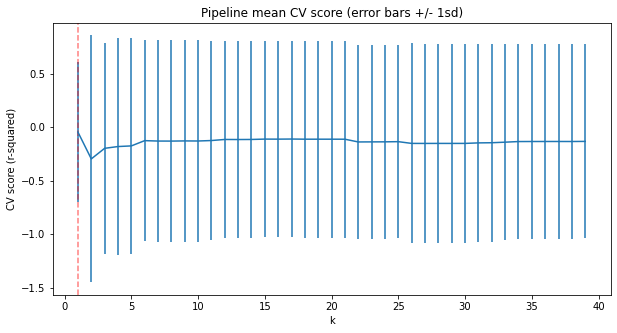

In [57]:
best_k = gridcv_lm.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Model 2: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#### a. Baseline Model

In [156]:
# Initialize model
RFreg = RandomForestRegressor(random_state=0)

# Fit and evaluate model
print_eval(RFreg, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.98  |  Test R2: 0.32 
Train RMSE: 1,205,631.86  |  Test RMSE: 19,645,793.77 
Train MAE: 47,979.83  |  Test MAE: 311,825.08


#### b. Tuning Hyperparameters

In [125]:
# Set hyperparameters to search over

n_est = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_feat = ['auto','sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(start=10,stop=100,num=10)]

param_grid_RF = [
    {'n_estimators':n_est, 'max_features':max_feat,
    'max_depth':max_depth, 'bootstrap':[True, False]}]

In [126]:
# Randomized Search CV

randomcv_rf = RandomizedSearchCV(RF, param_distributions=param_grid_RF, cv=5, scoring=['r2','neg_root_mean_squared_error'],
                                 refit='neg_root_mean_squared_error', n_iter=50, n_jobs=-1)
randomcv_rf.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2', None],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500, 600, 700, 800,
                                                          900, 1000]}],
                   refit='neg_root_mean_squared_error',
                   scoring=['r2', 'neg_root_mean_squared_error'])

In [127]:
# Best estimator properties

randomcv_rf.best_estimator_, randomcv_rf.best_params_, -randomcv_rf.best_score_

(RandomForestRegressor(max_depth=60, n_estimators=300, random_state=0),
 {'n_estimators': 300,
  'max_features': 'auto',
  'max_depth': 60,
  'bootstrap': True},
 2862730.7775639435)

In [157]:
print_eval(randomcv_rf.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.98  |  Test R2: 0.33 
Train RMSE: 1,149,503.61  |  Test RMSE: 19,626,271.12 
Train MAE: 46,619.97  |  Test MAE: 314,730.66


In [29]:
# Make pipeline
pipe_rf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=0))

# Cross-validation
cv_rf_results = cross_validate(pipe_rf, X_train, y_train, scoring='r2', cv=5)
cv_rf_scores = cv_rf_results['test_score']
np.mean(cv_rf_scores), np.std(cv_rf_scores)

(0.8772117951982505, 0.08747744972362777)

### Model 3: Gradient Boosting Regression

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

#### a. Baseline Model

In [154]:
# Initialize model
GBreg = GradientBoostingRegressor(random_state=0)

# Fit, predict, and evaluate
print_eval(GBreg, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 1.00, Test R2: 0.38 
Train RMSE: 515,410.84, Test RMSE: 18,734,783.10 
Train MAE: 162,533.20, Test MAE: 414,546.23


#### b. Tuning Hyperparameters

In [160]:
# Define hyperparameters to search over

n_est = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_feat = ['auto','sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]

param_grid_GB = [
    {'n_estimators':n_est, 'max_depth':max_depth, 'max_features':max_feat,
     'learning_rate':learning_rate}]

In [164]:
# Randomized Search CV

randomcv_gb = RandomizedSearchCV(GBreg, param_distributions=param_grid_GB, cv=5, scoring=['r2','neg_root_mean_squared_error'],
                                 refit='r2', n_iter=50, n_jobs=-1)
randomcv_gb.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions=[{'learning_rate': [0.001, 0.01, 0.1,
                                                           0.2, 0.3, 0.4],
                                         'max_depth': [10, 20, 30, 40, 50, 60,
                                                       70, 80, 90, 100],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2', None],
                                         'n_estimators': [100, 200, 300, 400,
                                                          500, 600, 700, 800,
                                                          900, 1000]}],
                   refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [162]:
# Best estimator properties

randomcv_gb.best_estimator_, randomcv_gb.best_params_, -randomcv_gb.best_score_

(GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                           n_estimators=900, random_state=0),
 {'n_estimators': 900,
  'max_features': 'sqrt',
  'max_depth': 10,
  'learning_rate': 0.01},
 3781905.1259770645)

In [165]:
# Best estimator properties

randomcv_gb.best_estimator_, randomcv_gb.best_params_, -randomcv_gb.best_score_

(GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                           n_estimators=500, random_state=0),
 {'n_estimators': 500,
  'max_features': 'sqrt',
  'max_depth': 10,
  'learning_rate': 0.01},
 -0.7951205048651334)

In [163]:
print_eval(randomcv_gb.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 1.00  |  Test R2: 0.24 
Train RMSE: 26,933.87  |  Test RMSE: 20,807,220.01 
Train MAE: 13,623.50  |  Test MAE: 536,715.37


In [166]:
print_eval(randomcv_gb.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 1.00  |  Test R2: 0.24 
Train RMSE: 110,101.06  |  Test RMSE: 20,823,268.66 
Train MAE: 43,307.32  |  Test MAE: 555,084.74
